In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

Then, we create a low-frequency noise by simulating deeper dipole sources

In [3]:
# deep_dipole_coordinates = (
#     [ 300,  750, 1200, 300, 1200, 1750],  # µm
#     [ 300, 1000, 1700, 1600, 300, 1000],  # µm
#     [-600, -600, -600, -600, -600, -600],  # µm
# )
# deep_dipole_moments = mg.angles_to_vector(
#     inclination=[-90, 90, -90, 90, 90, -90],
#     declination=[0, 0, 0, 0, 0, 0],
#     amplitude=[1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10],
# )

Now create the dipole model that will be used to generate the data.

In [4]:
sourcers1 = 70
sourcers2 = 30
np.random.seed(5)

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [ 500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, sourcers1+sourcers2), [-15, -15, -30]]),  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(0, 10, sourcers2), [10, -10, -5]]),
    declination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(180, 10, sourcers2), [10, 170, 190]]),
    amplitude=np.concatenate([abs(np.random.normal(0, 100, sourcers1+sourcers2))*1.0E-14, [5e-11, 5e-11, 5e-11]]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print()

In [5]:
# bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
# data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 -4.643 -4.693 -4.744 ... 0.004321 -0.02257 -0.04858

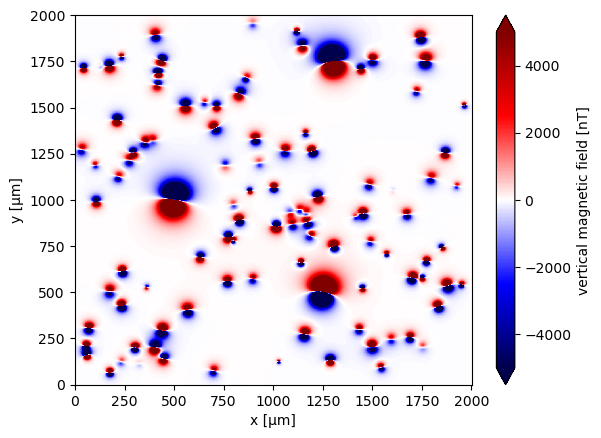

In [6]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)

Add some random noise to make it more realistic.

In [7]:
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

# data.bz.values += 2000

Add a polynomial shift to the data

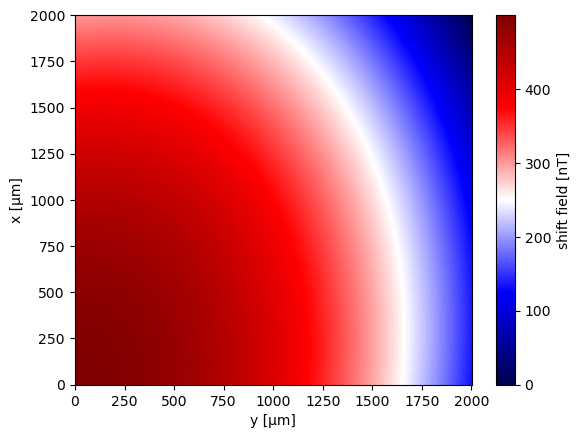

In [8]:
# a, b, c, d, e, f, g = 1, 2, -1, 3, -2, 1, 0.5
# a, b, c, d, e, f, g = 1.0, 0.5, 0.2, -1.0, 0.8, -2.0, 0.3
# pol = (a * data['x']**2 + b * data['y']**2 + c * data['x'] * data['y'] + d * data['x'] + e * data['y'] + f + g * data['y']**2)
# data['poly'] = (pol/pol.values.max())*2000


a, b, c, d, e, f, g = 3, 5, -1, 3, -5, 10, 0.5
pol = (a * data['x']**2 + b * data['y']**2 + c * data['x'] * data['y'] + d * data['x'] + e * data['y'] + f + g * data['y']**2)
data['poly'] = abs((pol/pol.values.max())-(pol/pol.values).max())*500

data.poly.attrs = {"long_name": "shift field", "units": "nT"}


data.bz.values += data.poly.values 

data.poly.plot.pcolormesh(cmap="seismic")#, vmax=10000, vmin=-10000)

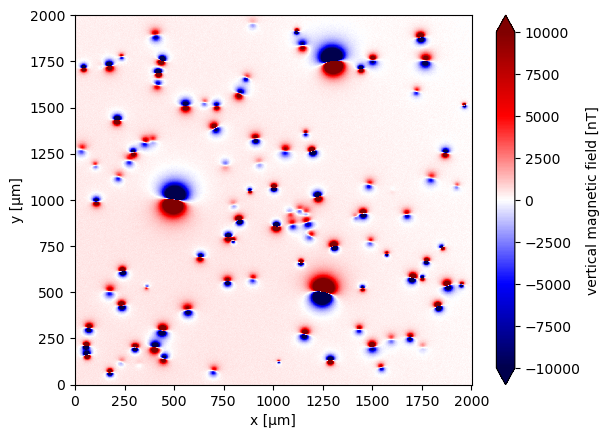

In [9]:
# median = np.median(data.bz.values)
# data.bz.values -= median

data_copy = data.copy(deep=True)
data_copy2 = data_copy.copy(deep=True)

data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Regional Separation

In [10]:
# regional = vd.Trend(degree=1).fit(coordinates, data.bz.values)
# data = data.assign(
#     regional_predicted=regional.predict((data.x, data.y)),
# )
# data.bz.values -= data.regional_predicted.values
# data


data_table = vd.grid_to_table(data)

regional = vd.Trend(degree=1).fit((data_table.x, data_table.y), data.bz.values.ravel())

shape = data.bz.shape
regional_predicted=regional.predict((data_table.x, data_table.y))
regional_predicted = np.reshape(regional_predicted, shape)


data = data.assign(regional_predicted=(("y", "x"), regional_predicted))
data.regional_predicted.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

# data.bz.values -= data.regional_predicted.values

data

<xarray.Dataset>
Dimensions:             (y: 1001, x: 1001)
Coordinates:
  * x                   (x) float64 0.0 2.0 4.0 ... 1.996e+03 1.998e+03 2e+03
  * y                   (y) float64 0.0 2.0 4.0 ... 1.996e+03 1.998e+03 2e+03
    z                   (y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
Data variables:
    bz                  (y, x) float64 510.6 443.3 532.8 ... -16.23 -30.18
    poly                (x, y) float64 500.0 500.0 500.0 ... 1.332 0.6662 0.0
    regional_predicted  (y, x) float64 579.7 579.4 579.1 ... 82.95 82.62 82.3

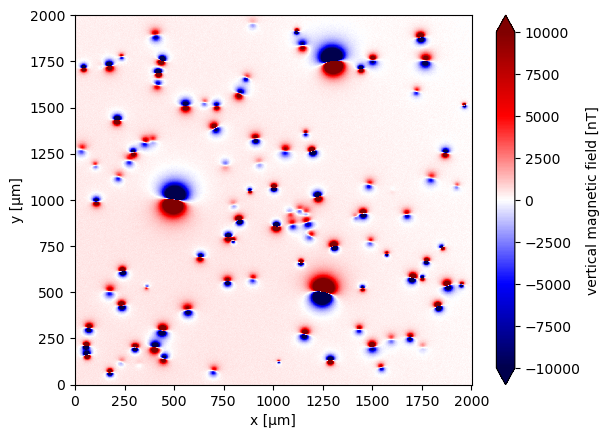

In [11]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [12]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 268.6 306.0 333.0 350.5 ... 128.8 144.6 169.4 205.2

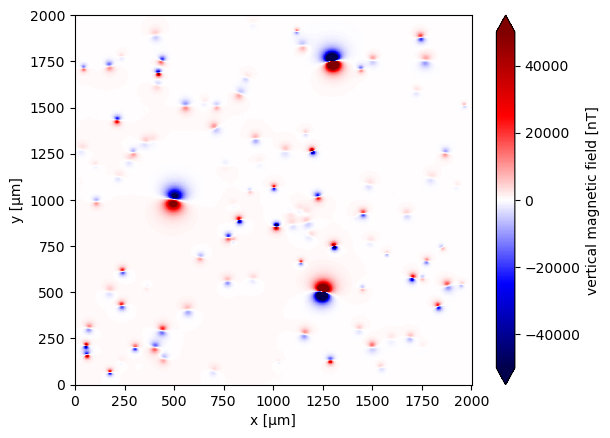

In [13]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [14]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 268.6 306.0 333.0 350.5 ... 128.8 144.6 169.4 205.2
    tga      (y, x) float64 21.86 22.25 20.04 17.54 ... 17.05 19.77 22.29 21.74
    x_deriv  (y, x) float64 18.7 16.09 11.11 7.217 ... 6.41 10.15 15.16 17.91
    y_deriv  (y, x) float64 9.292 9.126 9.111 9.473 ... 8.565 8.68 8.839 8.926
    z_deriv  (y, x) float64 -6.445 -12.37 -13.97 -12.88 ... 14.58 13.75 8.514

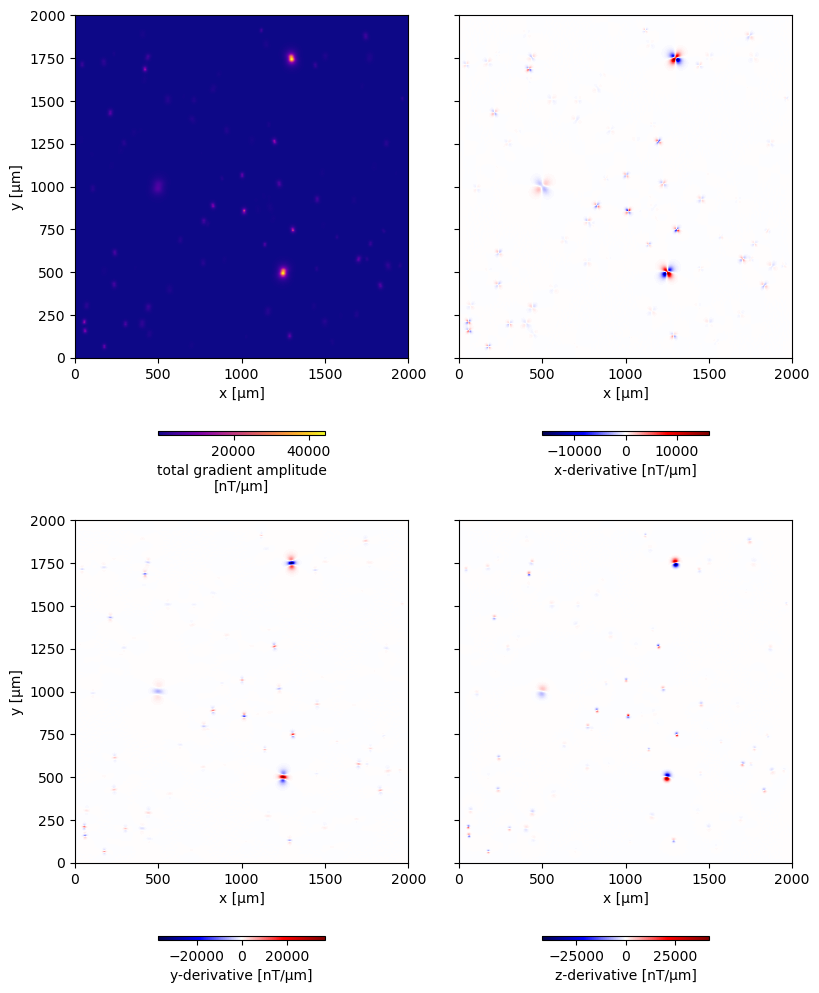

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [16]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

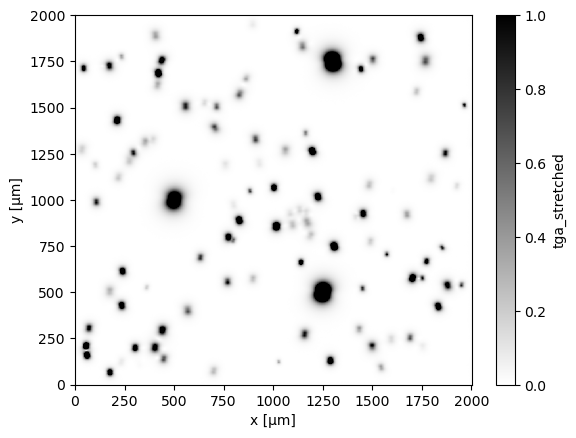

In [17]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [18]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 150],
    size_increment=1.3,
    threshold=0.01,
    overlap=0.3,
    exclude_border=15
)
# windows
end_detection_time = time.perf_counter()

In [19]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

99 potential sources detected within 2.3404 seconds


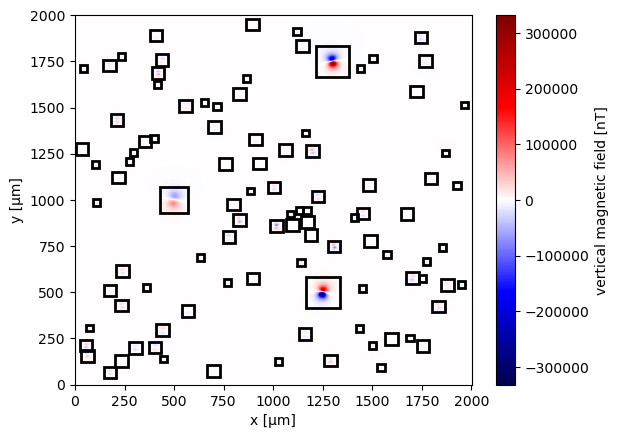

In [20]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [21]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False # position[2] > 0
    poor_fit = False
    
#     bad_euler = position[2] > 0
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [22]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

99 euler positions and dipole moments estimated within 1.6758 seconds


Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [23]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([ 1.93204661e-01,  1.92464983e-01,  3.86111329e-01,  3.90885145e-01,
        3.89982310e-01,  3.62142423e-01,  1.16054309e-01,  3.06286586e-01,
        2.65677758e-01,  3.29066621e-01,  3.24173961e-01,  5.12676347e-01,
        3.54381533e-01,  3.33624840e-01,  3.26299743e-01,  2.95629917e-01,
        3.90466340e-01,  3.25378157e-01,  4.68912291e-01,  2.14074534e-01,
       -8.94814336e-03,  4.26048508e-01,  3.65410078e-01,  5.15184662e-01,
        3.58225548e-01,  3.29252867e-01,  6.76584736e-01,  1.03606324e-01,
        1.96573994e-01,  9.76981107e-02,  1.83847982e-01,  2.13523109e-01,
        3.03320706e-01,  3.26857812e-01,  2.44153660e-01,  4.29845068e-01,
        2.90617943e-01, -7.79593128e-01,  3.26314609e-01,  3.54292063e-01,
        3.98134630e-01,  2.66578536e-01,  4.02540788e-01,  2.04041371e-01,
        1.24175671e+00,  3.78926212e-01,  2.77853515e-01,  4.87121805e-03,
        3.42428197e-01,  2.49903780e-01,  1.41349441e-01,  3.45263483e-01,
        3.39324706e-01,  

In [24]:
# Misfits alculation
direction_misfit = []
magnetic_moment_misfit = []

for estimated, true in zip(estimated_dipole_moments, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)

/tmp/ipykernel_85552/3758845858.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dir_misfit = float(np.degrees(mplstereonet.angular_distance(


# Iterative Euler deconvolution

In [25]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []
calculated_SNR_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

################################# identify and remove all models with r2 >= 0.99 at once
euler_r2 = np.array(calculated_r2) > 1.01

for window in rich.progress.track(np.array(windows)[euler_r2], total = len(np.array(windows)[euler_r2])):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    data_minus_background = anomaly.bz.values #- base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    # store the results with the itr Euler (without interfering sources)
    estimated_dipole_moments_itr_euler.append(moment)

      ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])  
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)
    
# remove all signals 
position = np.array([xc_concat, yc_concat, zc_concat])
discard = mg.dipole_bz(coordinates, position, estimated_dipole_moments_itr_euler)
data_copy.bz.values -= discard



#################################
for window in rich.progress.track(np.array(windows)[~euler_r2], total = len(np.array(windows)[~euler_r2])):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     # using the real data to perform the dipole moment estimation
#     data_minus_background = data_copy['bz'].sel(x=slice(*window[:2]), y=slice(*window[2:])).values 
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

    # index = vd.inside(dipole_coordinates, window)
    # position = (dipole_coordinates[0][index][0],
    #             dipole_coordinates[1][index][0],
    #             dipole_coordinates[2][index][0])
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    # store the results with the itr Euler (without interfering sources)
    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)
    calculated_SNR_itr_euler = np.append(calculated_SNR_itr_euler, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

Output()

In [26]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 32.7843 seconds


In [27]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

,x,y,z,bz,z_deriv
0,1166.0,416.0,10.0,-545.145833,-46.960261
1,1168.0,416.0,10.0,-605.998530,-51.154112
2,1170.0,416.0,10.0,-671.178900,-53.230188
3,1172.0,416.0,10.0,-739.770649,-55.712828
4,1174.0,416.0,10.0,-810.985528,-59.929576


In [28]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])
print(positions_itr)

[[ 1.24999897e+03  1.29999950e+03  1.19800141e+03  1.30799974e+03
   1.01602269e+03  8.29012607e+02  5.00001546e+02  2.13002949e+02
   1.22604809e+03  1.28900286e+03  1.83302903e+03  4.21064560e+02
   1.70325060e+03  2.35849480e+02  1.74502800e+03  1.11889726e+03
   1.00400078e+03  2.39981594e+02  1.13999968e+03  1.45424934e+03
   4.41165867e+02  1.77022927e+02  3.04075706e+02  7.75359049e+02
   1.77400915e+03  4.39869625e+01  4.38008920e+02  6.10804462e+01
   1.44276825e+03  4.05047758e+02  5.70106469e+01  1.87990231e+03
   1.73640342e+02  7.09959790e+01  1.86901434e+03  1.96500803e+03
   1.15899771e+03  2.96118917e+02  7.69957747e+02  1.85300488e+03
   1.49999899e+03  1.07980607e+02  1.57299935e+03  5.58002618e+02
   1.75292197e+03  1.45101032e+03  6.33009177e+02  1.95103013e+03
   8.83006155e+02  9.11027099e+02  7.05923980e+02  1.76897204e+03
   1.50302940e+03  7.14842111e+02  4.48000765e+02  1.69115377e+03
   5.68985088e+02  8.30932106e+02  1.14808937e+03  1.16396200e+03
   4.07010

In [29]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions_itr))[1]
z_difference_itr = positions_itr[2] - np.array(dipole_coordinates[2])[closest]
z_difference_itr

array([ 0.19320466,  0.19247558,  0.38607066,  0.3855472 ,  0.3903836 ,
        0.36163667,  0.11613171,  0.30574467,  0.2683025 ,  0.32932973,
        0.32439547,  0.51255902,  0.35374138,  0.33391449,  0.32601188,
        0.31144   ,  0.38993592,  0.32462521,  0.43063659,  0.21067521,
       -0.00891226,  0.42596065,  0.36065593,  0.52474297,  0.3269266 ,
        0.329026  ,  0.30681089,  0.1036781 ,  0.26279726,  0.40529079,
        0.43495502,  0.18524396,  0.30607811,  0.27076459,  0.24446898,
        0.43030909,  0.20592632, -0.80059173,  0.32948038,  0.35760187,
        0.39882838,  0.26962918,  0.39759876,  0.19485598,  0.38593112,
        0.32772566,  0.26170201,  0.33515401,  0.35151331,  0.25060708,
        0.15917527,  0.20987049,  0.331867  ,  0.35772744,  0.27384995,
        0.26986975,  0.19664835, -0.01862635,  0.16458448,  0.35114003,
        0.19539755,  0.30416516,  0.2246399 ,  0.3506898 ,  0.28027728,
        3.60841476,  0.22093893,  0.37420388,  0.42220778, -2.07

# Comparison plots

## Euler comparison

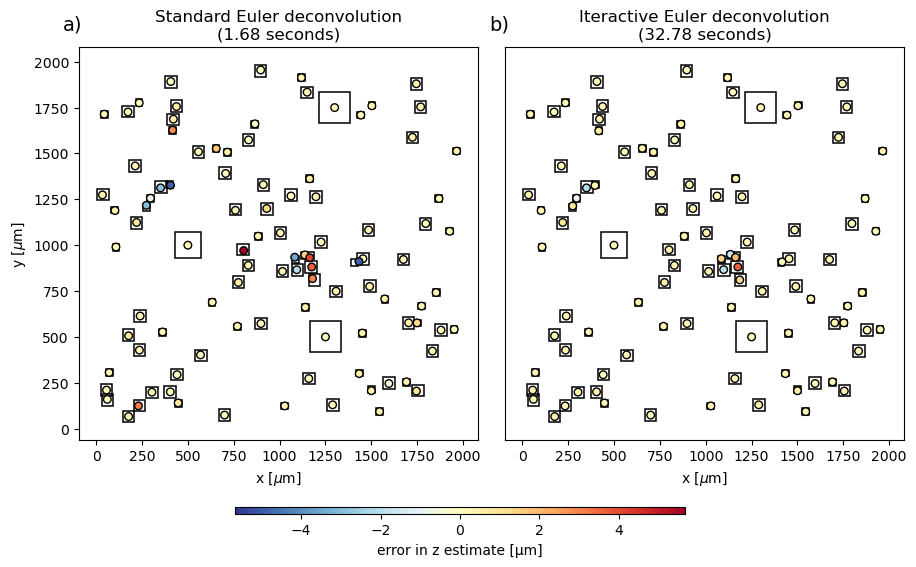

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

scale = vd.maxabs((z_difference, z_difference_itr))

ax = axes[0]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

ax = axes[1]
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)

tmp = ax.scatter(*positions_itr[:2], c=z_difference_itr, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

titles = ([r'Standard Euler deconvolution'   +'\n'+ f'({round(inversion_time, 2)} seconds)', 
           r'Iteractive Euler deconvolution' +'\n'+ f'({round(itr_euler_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.set_xlabel(r"x [$\mu$m]")

axes[1].set_yticks([])
axes[0].set_ylabel(r"y [$\mu$m]")
plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.25, 0.2, 0.5, 0.0075]))


plt.show()

## Directions and Dipole Moments comparions

### Iteractive Euler (withou interf. sources)

In [31]:
# Misfits alculation
direction_misfit_itr_euler = []
magnetic_moment_misfit_itr_euler = []

for estimated, true in zip(estimated_dipole_moments_itr_euler, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit_itr_euler.append(dir_misfit)
    magnetic_moment_misfit_itr_euler.append(magm_mom_misfit)

/tmp/ipykernel_85552/691881143.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dir_misfit = float(np.degrees(mplstereonet.angular_distance(


### Interfering sources method with $b_z$ vector

In [32]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER

def all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['bz']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['bz']).ravel() / TESLA_TO_NANOTESLA #table.bz.values / TESLA_TO_NANOTESLA
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment 

@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant * choclo.point.kernel_eu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant * choclo.point.kernel_nu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant * choclo.point.kernel_uu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            


In [33]:
start_interf_bz_time = time.perf_counter()

estimated_dipole_moments_interf_bz = all_dipole_moment_inversion(df, positions_itr)
# print(estimated_dipole_moments_interf_bz)

end_interf_bz_time = time.perf_counter()

In [34]:
interf_bz_time = end_interf_bz_time-start_interf_bz_time
print(f"Time for the iterative Euler solution and interfering sources bz estimation: {round(itr_euler_time+interf_bz_time, 2)} seconds", )

Time for the iterative Euler solution and interfering sources bz estimation: 33.37 seconds


In [35]:
# Misfits alculation
direction_misfit_interf_bz = []
magnetic_moment_misfit_interf_bz = []

for estimated, true in zip(estimated_dipole_moments_interf_bz, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit_interf_bz.append(dir_misfit)
    magnetic_moment_misfit_interf_bz.append(magm_mom_misfit)

/tmp/ipykernel_85552/2926773584.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dir_misfit = float(np.degrees(mplstereonet.angular_distance(


### Interfering sources method with $\frac{\partial b_z}{\partial z}$ vector

In [36]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER


from numba import jit

@jit(nopython=True)
def kernel_uuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along upward-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.


    """
    return 9 * (upward_p - upward_q) / distance**5 - 15 * (upward_p - upward_q)**3 / distance**7



@jit(nopython=True)
def kernel_euu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (easting_p - easting_q) / distance**5 
            - 15 * (easting_p - easting_q) * (upward_p - upward_q)**2 / distance**7)


@jit(nopython=True)
def kernel_nuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (northing_p - northing_q) / distance**5 
            - 15 * (northing_p - northing_q) * (upward_p - upward_q)**2 / distance**7)


def z_deriv_all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['z_deriv']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['z_deriv']).ravel() #*-1.0e-3 # CONVERTING nT/microm to T/m
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment * 1.0e-3


@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant*kernel_euu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant*kernel_nuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant*kernel_uuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            

In [37]:
start_interf_z_deriv_time = time.perf_counter()

estimated_dipole_moments_interf_z_deriv = z_deriv_all_dipole_moment_inversion(df, positions_itr)
# print(estimated_dipole_moments_interf_bz)

end_interf_z_deriv_time = time.perf_counter()

In [38]:
interf_z_deriv_time = end_interf_z_deriv_time-start_interf_z_deriv_time
print(f"Time for the iterative Euler solution and interfering sources bz estimation: {round(itr_euler_time+interf_z_deriv_time, 2)} seconds", )

Time for the iterative Euler solution and interfering sources bz estimation: 33.52 seconds


In [39]:
# Misfits alculation
direction_misfit_interf_z_deriv = []
magnetic_moment_misfit_interf_z_deriv = []

for estimated, true in zip(estimated_dipole_moments_interf_z_deriv, dipole_moments[closest]):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit_interf_z_deriv.append(dir_misfit)
    magnetic_moment_misfit_interf_z_deriv.append(magm_mom_misfit)

/tmp/ipykernel_85552/3414570744.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dir_misfit = float(np.degrees(mplstereonet.angular_distance(


### Directions comparisons

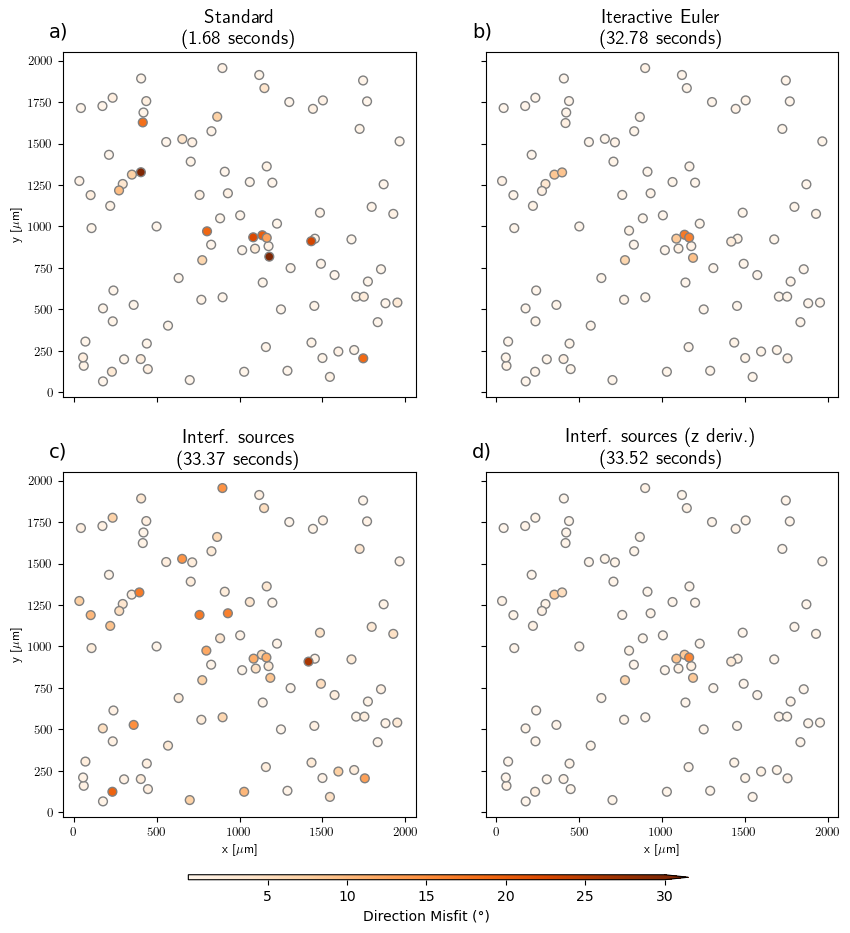

In [40]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey="row", sharex='col')
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
    
    scale = 30
    ax = axes[0]
    ax.set_title("Direction Misfit Standard"+'\n'+ f'({round(inversion_time, 2)} seconds)', fontsize=13)    
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[1]
    ax.set_title("Direction Misfit Interf. Sources"+'\n'+ f'({round(itr_euler_time, 2)} seconds)', fontsize=13)
    tmp = ax.scatter(*positions_itr[:2], c=direction_misfit_itr_euler, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[2]
    ax.set_title("Direction Misfit Interf. Sources"+'\n'+ f'({round(itr_euler_time+interf_bz_time, 2)} seconds)', fontsize=13)    
    tmp = ax.scatter(*positions_itr[:2], c=direction_misfit_interf_bz, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[3]   
    ax.set_title("Direction Misfit Interf. Sources Z-deriv"+'\n'+ f'({round(itr_euler_time+interf_z_deriv_time, 2)} seconds)', fontsize=13)
    tmp = ax.scatter(*positions_itr[:2], c=direction_misfit_interf_z_deriv, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')


fig.colorbar(tmp, **cbar_kwargs, label="Direction Misfit (°)", cax=fig.add_axes([0.25, 0.05, 0.5, 0.0050]), extend='max')

titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)', 
           'Interf. sources'+'\n'+ f'({round(itr_euler_time+interf_bz_time, 2)} seconds)', 
           'Interf. sources (z deriv.)'+'\n'+ f'({round(itr_euler_time+interf_z_deriv_time, 2)} seconds)'])
for ax, letter, title in zip(axes, "a b c d".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title, fontsize=14)


axes[0].set_ylabel(r"y [$\mu$m]")
axes[2].set_ylabel(r"y [$\mu$m]")
axes[2].set_xlabel(r"x [$\mu$m]")
axes[3].set_xlabel(r"x [$\mu$m]")

plt.show()   

### Dipole moment comparison

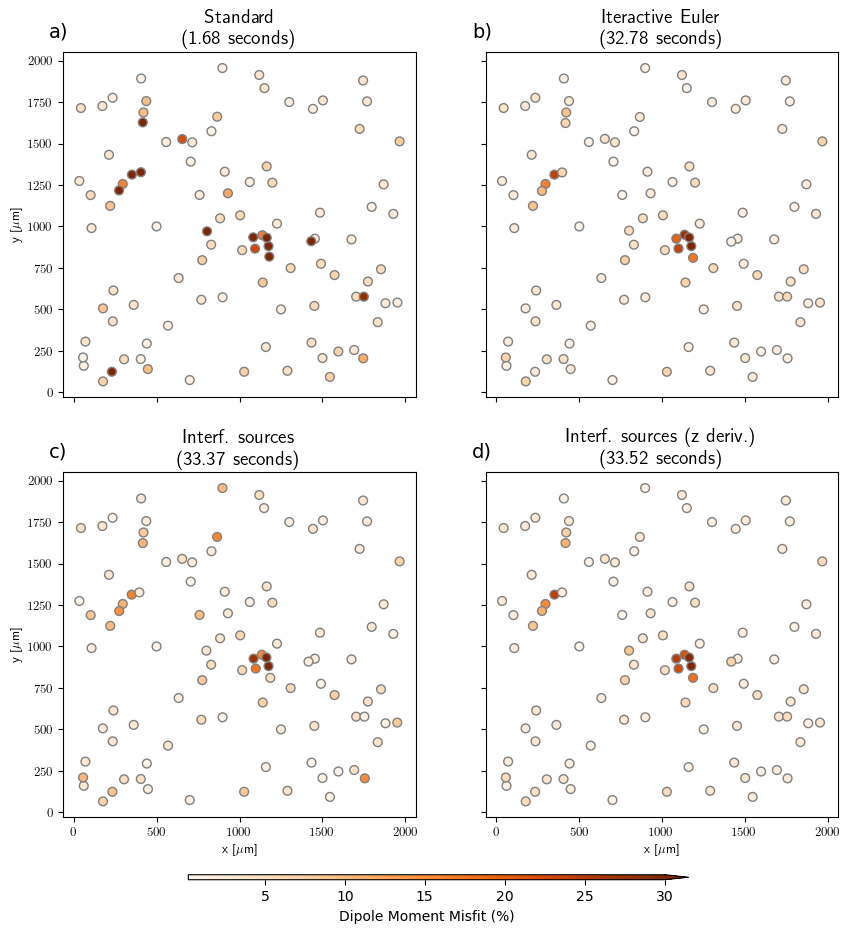

In [41]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey="row", sharex='col')
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
    
    scale = 30
    ax = axes[0]
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    
    ax = axes[1]
    tmp = ax.scatter(*positions_itr[:2], c=magnetic_moment_misfit_itr_euler, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
        
    ax = axes[2]
    tmp = ax.scatter(*positions_itr[:2], c=magnetic_moment_misfit_interf_bz, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    
    ax = axes[3]
    tmp = ax.scatter(*positions_itr[:2], c=magnetic_moment_misfit_interf_z_deriv, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')


fig.colorbar(tmp, **cbar_kwargs, label="Dipole Moment Misfit (%)", cax=fig.add_axes([0.25, 0.05, 0.5, 0.0050]), extend='max')

titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)', 
           'Interf. sources'+'\n'+ f'({round(itr_euler_time+interf_bz_time, 2)} seconds)', 
           'Interf. sources (z deriv.)'+'\n'+ f'({round(itr_euler_time+interf_z_deriv_time, 2)} seconds)'])

for ax, letter, title in zip(axes, "a b c d".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title, fontsize=14)

axes[0].set_ylabel(r"y [$\mu$m]")
axes[2].set_ylabel(r"y [$\mu$m]")
axes[2].set_xlabel(r"x [$\mu$m]")
axes[3].set_xlabel(r"x [$\mu$m]")

plt.show()

### R² comparison

In [42]:
def calculated_r2_interf_sources_bz(data, coordinates, dipole_coordinates, dipole_moments, 
                                 windows, height_difference):
    calculated_r2_interf = []
    
    # Calculate predicted model
    predicted_model = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
    
    # Calculate predicted model 
    predicted = vd.make_xarray_grid(coordinates, predicted_model, data_names=["bz"], 
                                    dims=("y", "x"), extra_coords_names="z")
    predicted.x.attrs = {"units": "µm"}
    predicted.y.attrs = {"units": "µm"}
    predicted.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
    
    # Upward continuation of the predicted model 
    pred_up = (
                hm.upward_continuation(predicted.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    # Upward continuation of data
    
    data_up = (
                hm.upward_continuation(data.bz, height_difference)
                .assign_attrs(data.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    
    # Calculate r2 of each window
    for window in windows:
        data_up_slice = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        pred_up_slice = pred_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        residuals = data_up_slice.bz.values - pred_up_slice.bz.values
        residuals_sum_sq = np.sum(residuals**2)
        
        # R² Coeficient of Determination (dimensionless)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_up_slice.bz.values - np.mean(data_up_slice.bz.values)) ** 2
        
        calculated_r2_interf.append(r2)
    
    return np.array(calculated_r2_interf)



def calculated_r2_interf_sources_bzz(data, coordinates, dipole_coordinates, dipole_moments, 
                                 windows, height_difference):
    calculated_r2_interf = []
    
    # Calculate predicted model
    predicted_model = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
    
    # Calculate predicted model 
    predicted = vd.make_xarray_grid(coordinates, predicted_model, data_names=["bz"], 
                                    dims=("y", "x"), extra_coords_names="z")
    predicted.x.attrs = {"units": "µm"}
    predicted.y.attrs = {"units": "µm"}
    predicted.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
    
    # Upward continuation of the predicted model 
    pred_up = (
                hm.upward_continuation(predicted.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    # Upward continuation of data
    
#     # remove median
#     median = np.median(data.bz.values)
#     data.bz.values -= median
    
    data_up = (
                hm.upward_continuation(data.bz, height_difference)
                .assign_attrs(data.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    
    data_up = data_up.assign(mg.data_gradients(data_up.bz))
    pred_up = data_up.assign(mg.data_gradients(pred_up.bz))
    
    # Calculate r2 of each window
    for window in windows:
        data_up_slice = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        pred_up_slice = pred_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        residuals = data_up_slice.z_deriv.values - pred_up_slice.z_deriv.values
        residuals_sum_sq = np.sum(residuals**2)
        
        # R² Coeficient of Determination (dimensionless)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_up_slice.z_deriv.values - np.mean(data_up_slice.z_deriv.values)) ** 2
        
        calculated_r2_interf.append(r2)
    
    return np.array(calculated_r2_interf)

In [43]:
warnings.filterwarnings("ignore")

calculated_r2_interf_bz = calculated_r2_interf_sources_bz(data, coordinates, positions_itr, 
                                                    estimated_dipole_moments_interf_bz, 
                                                    np.array(windows), height_difference)

calculated_r2_interf_z_deriv = calculated_r2_interf_sources_bzz(data, coordinates, positions_itr, 
                                                    estimated_dipole_moments_interf_z_deriv, 
                                                    np.array(windows), height_difference)

warnings.resetwarnings()


# r2 adjust


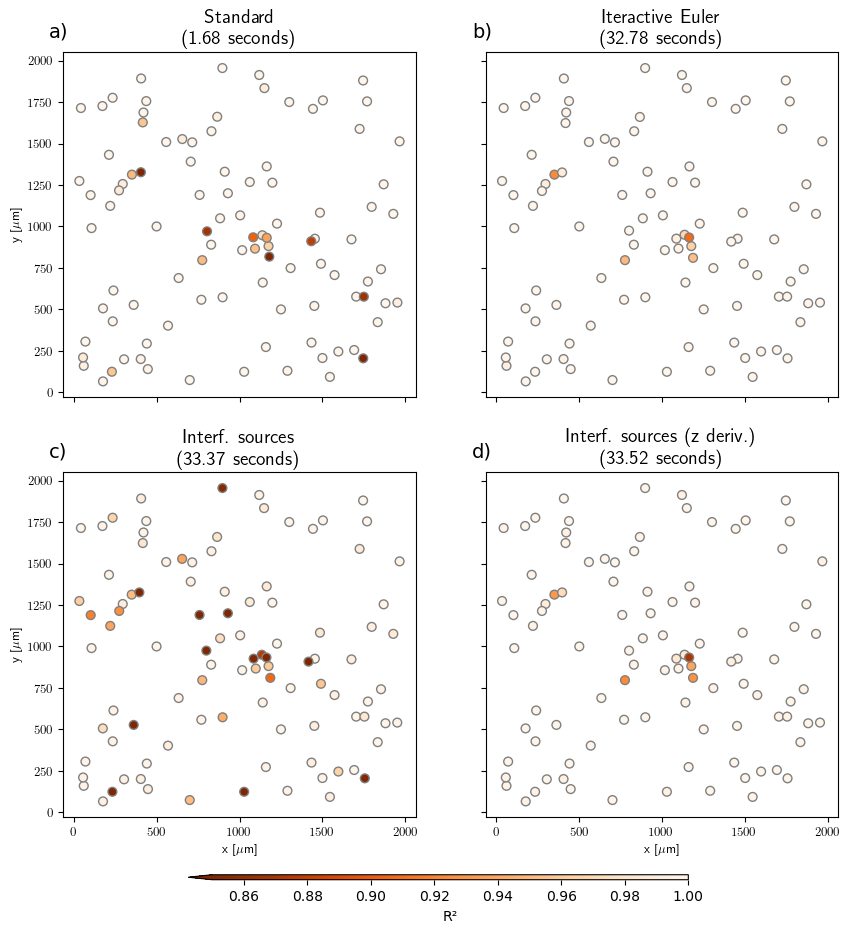

In [44]:
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey="row", sharex='col')
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
    
    scale = 1
    ax = axes[0]
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="Oranges_r", vmin=0.85, vmax=1.0,  edgecolor='gray')
    
    ax = axes[1]
    tmp = ax.scatter(*positions_itr[:2], c=calculated_r2_itr_euler, s=40, cmap="Oranges_r", vmin=0.85, vmax=1.0, edgecolor='gray')
        
    ax = axes[2]
    tmp = ax.scatter(*positions_itr[:2], c=calculated_r2_interf_bz, s=40, cmap="Oranges_r", vmin=0.85, vmax=1.0, edgecolor='gray')
    
    ax = axes[3]
    tmp = ax.scatter(*positions_itr[:2], c=calculated_r2_interf_z_deriv, s=40, cmap="Oranges_r", vmin=0.85, vmax=1.0, edgecolor='gray')


fig.colorbar(tmp, **cbar_kwargs, label="R²", cax=fig.add_axes([0.25, 0.05, 0.5, 0.0050]), extend='min')

titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)', 
           'Interf. sources'+'\n'+ f'({round(itr_euler_time+interf_bz_time, 2)} seconds)', 
           'Interf. sources (z deriv.)'+'\n'+ f'({round(itr_euler_time+interf_z_deriv_time, 2)} seconds)'])

for ax, letter, title in zip(axes, "a b c d".split(), titles):
    ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)
    ax.set_aspect("equal")
    ax.set_title(title, fontsize=14)

axes[0].set_ylabel(r"y [$\mu$m]")
axes[2].set_ylabel(r"y [$\mu$m]")
axes[2].set_xlabel(r"x [$\mu$m]")
axes[3].set_xlabel(r"x [$\mu$m]")

# fig.savefig("moment_comparison.png", dpi=300, facecolor='w', bbox_inches='tight')

plt.show()

In [45]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

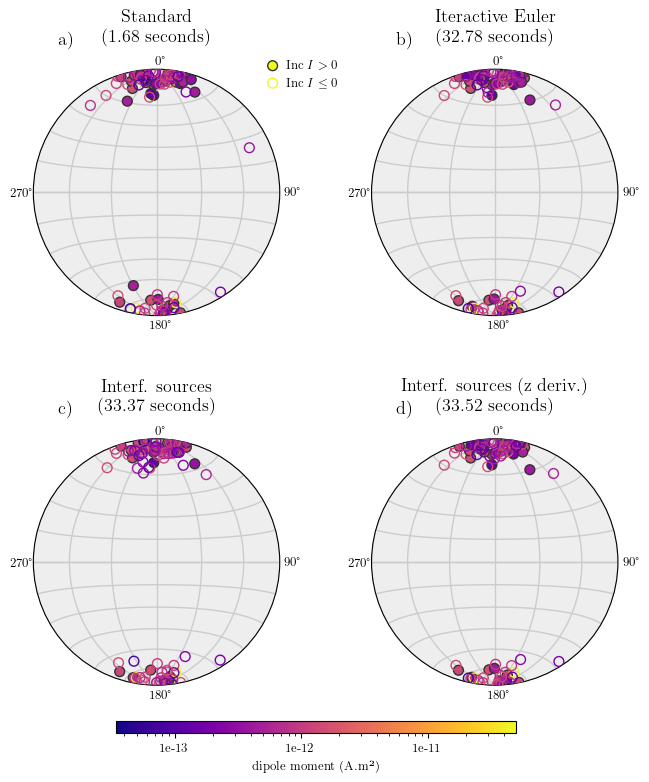

In [46]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 8))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]
    estimated3 = mg.vector_to_angles(estimated_dipole_moments_interf_bz)[2]
    estimated4 = mg.vector_to_angles(estimated_dipole_moments_interf_z_deriv)[2]
    
    vmin = np.min([np.min(estimated1),np.min(estimated2),np.min(estimated3),np.min(estimated4)])
    vmax = np.max([np.max(estimated1),np.max(estimated2),np.max(estimated3),np.max(estimated4)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
    ## STANDARD METHOD
    ax = fig.add_subplot(2, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(2, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    
    ## ITERACTIVE METHOD W/ Bz DATA
    ax = fig.add_subplot(2, 2, 3, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_interf_bz, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ## ITERACTIVE METHOD W/ Bz deriv DATA
    ax = fig.add_subplot(2, 2, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_interf_z_deriv, marker="o", zorder=1000, label="Inc", **kwargs)

    
    ######
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)', 
           'Interf. sources'+'\n'+ f'({round(itr_euler_time+interf_bz_time, 2)} seconds)', 
           'Interf. sources (z deriv.)'+'\n'+ f'({round(itr_euler_time+interf_z_deriv_time, 2)} seconds)'])

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


# Paper's figures 

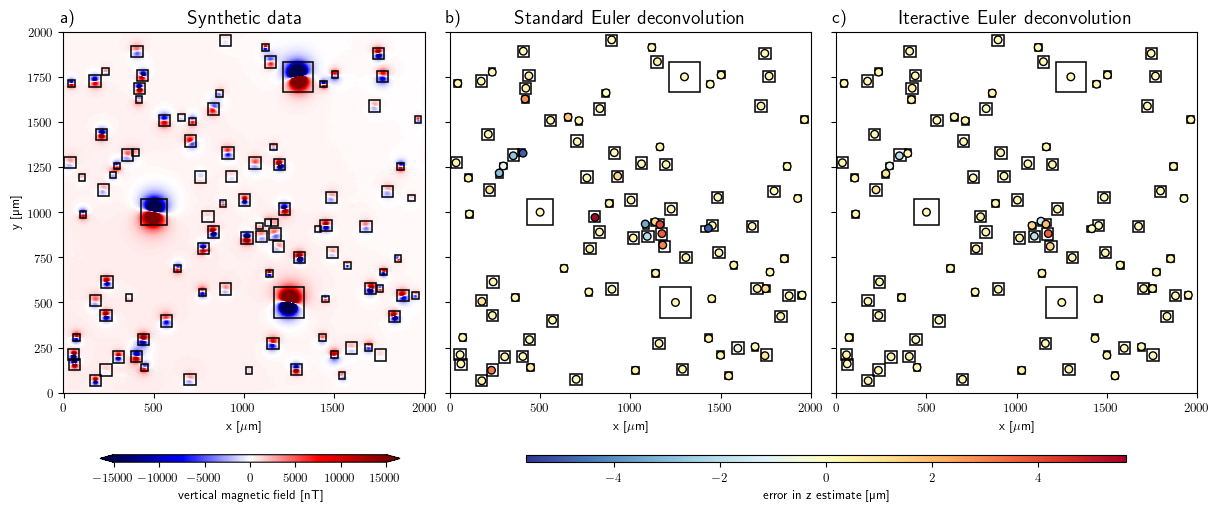

In [47]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((z_difference, z_difference_itr))

    ax = axes[1]
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    ax = axes[2]
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=z_difference_itr, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    titles = ([r'Synthetic data',
               r'Standard Euler deconvolution', 
               r'Iteractive Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, -0.00, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.43, -0.00, 0.5, 0.015]))
    # fig.savefig(fig_dir / "euler-comparion-2.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()


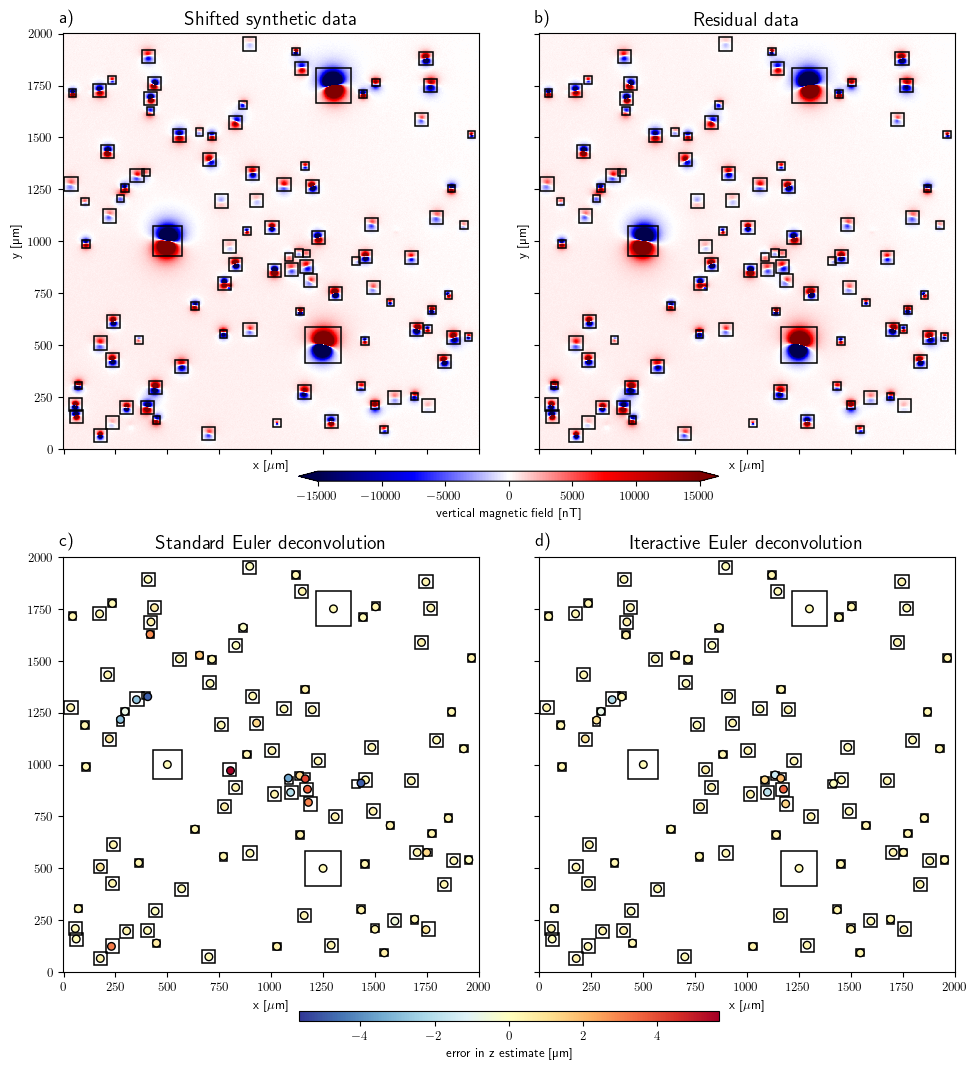

In [48]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_copy2['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    ax = axes[1]


    tmp1 = data['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((z_difference, z_difference_itr))

    ax = axes[2]
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    ax = axes[3]
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=z_difference_itr, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')

    titles = ([r'Shifted synthetic data',
               r'Residual data',
               r'Standard Euler deconvolution', 
               r'Iteractive Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=5.0, w_pad=-0.4)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.31, 0.53, 0.42, 0.01]))
    fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]", cax=fig.add_axes([0.31, -0.01, 0.42, 0.01]))
    fig.savefig(fig_dir / "euler-comparion-2.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()

/tmp/ipykernel_85552/1480886619.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0, h_pad=0.5, w_pad=0.0)


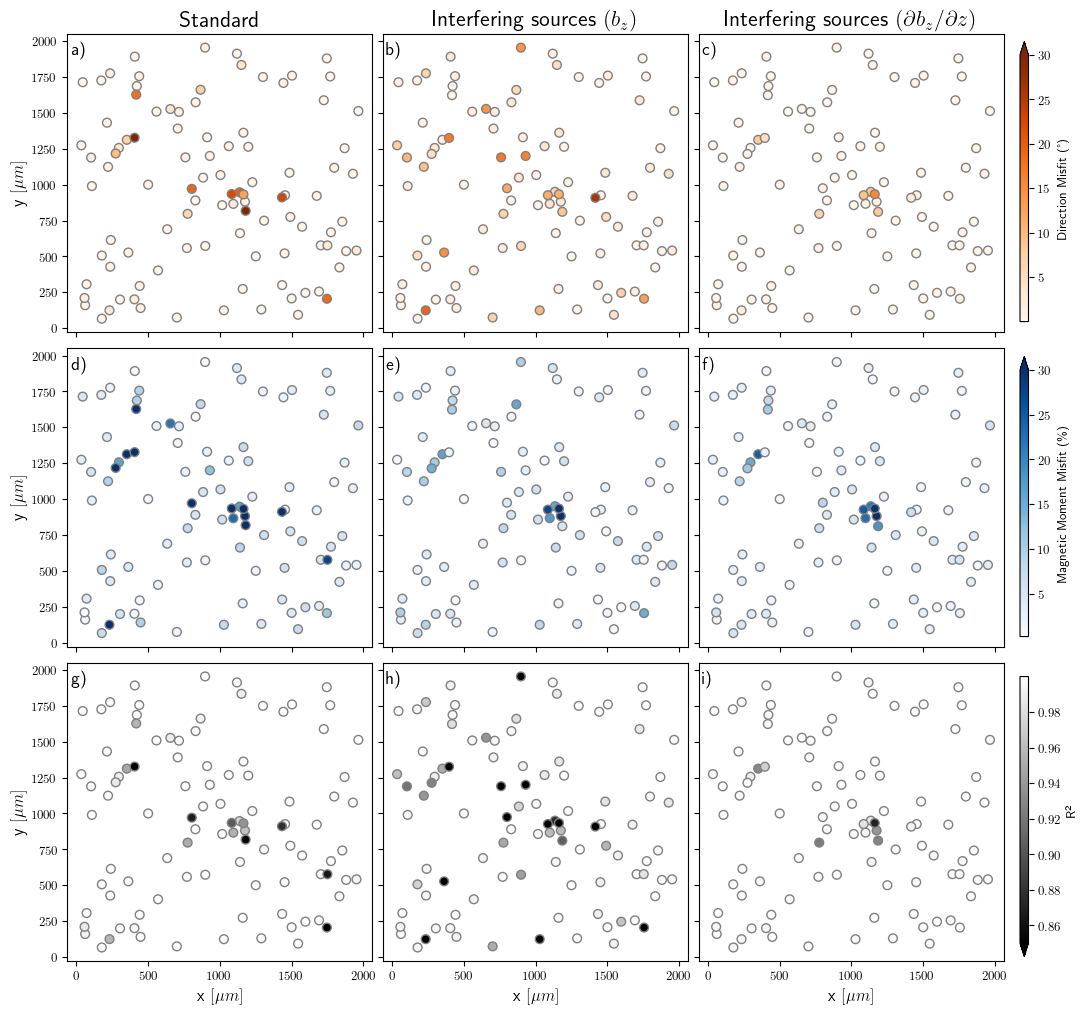

In [49]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharey="row", sharex='col')
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="vertical", aspect=40, pad=0.05, shrink=0.9)
    
    scale = 30
    ax = axes[0]
    ax.set_title("Standard", fontsize=16)    
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[1]
    ax.set_title(r"Interfering sources $(b_z)$", fontsize=16)
    tmp = ax.scatter(*positions_itr[:2], c=direction_misfit_interf_bz, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[2]
    ax.set_title(r"Interfering sources $(\partial b_z / \partial z)$", fontsize=16)    
    tmp = ax.scatter(*positions_itr[:2], c=direction_misfit_interf_z_deriv, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="Direction Misfit (°)", cax=fig.add_axes([1.01, 0.685, 0.0085, 0.28]), extend='max')
    
    
    scale = 30
    ax = axes[3] 
    tmp1 = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Blues", vmax=scale, edgecolor='gray')
    
    ax = axes[4]
    tmp = ax.scatter(*positions_itr[:2], c=magnetic_moment_misfit_interf_bz, s=40, cmap="Blues", vmax=scale, edgecolor='gray')
    
    ax = axes[5] 
    tmp = ax.scatter(*positions_itr[:2], c=magnetic_moment_misfit_interf_z_deriv, s=40, cmap="Blues", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label=r"Magnetic Moment Misfit (\%)", cax=fig.add_axes([1.01, 0.37, 0.0085, 0.28]), extend='max')
    
    scale = 0.85
    ax = axes[6] 
    tmp1 = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    
    ax = axes[7]
    tmp = ax.scatter(*positions_itr[:2], c=calculated_r2_interf_bz, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    
    ax = axes[8] 
    tmp = ax.scatter(*positions_itr[:2], c=calculated_r2_interf_z_deriv, s=40, cmap="gray", vmin=scale, vmax=1, edgecolor='gray')
    fig.colorbar(tmp1, **cbar_kwargs, label="R²", cax=fig.add_axes([1.01, 0.05, 0.0085, 0.28]), extend='min')

    for ax, letter in zip(axes, "a b c d e f g h i".split()):
        ax.text(0.01, 0.93, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

    axes[0].set_ylabel(r'y $[\mu m]$', fontsize=12)
    axes[3].set_ylabel(r'y $[\mu m]$', fontsize=12)
    axes[6].set_ylabel(r'y $[\mu m]$', fontsize=12)
    axes[6].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[7].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[8].set_xlabel(r'x $[\mu m]$', fontsize=12)

    plt.tight_layout(pad=0, h_pad=0.5, w_pad=0.0)
    # fig.savefig(fig_dir / "inversion-comparion-2.png", dpi=300, facecolor='w', bbox_inches='tight')

plt.show()   

/tmp/ipykernel_85552/1066031217.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)


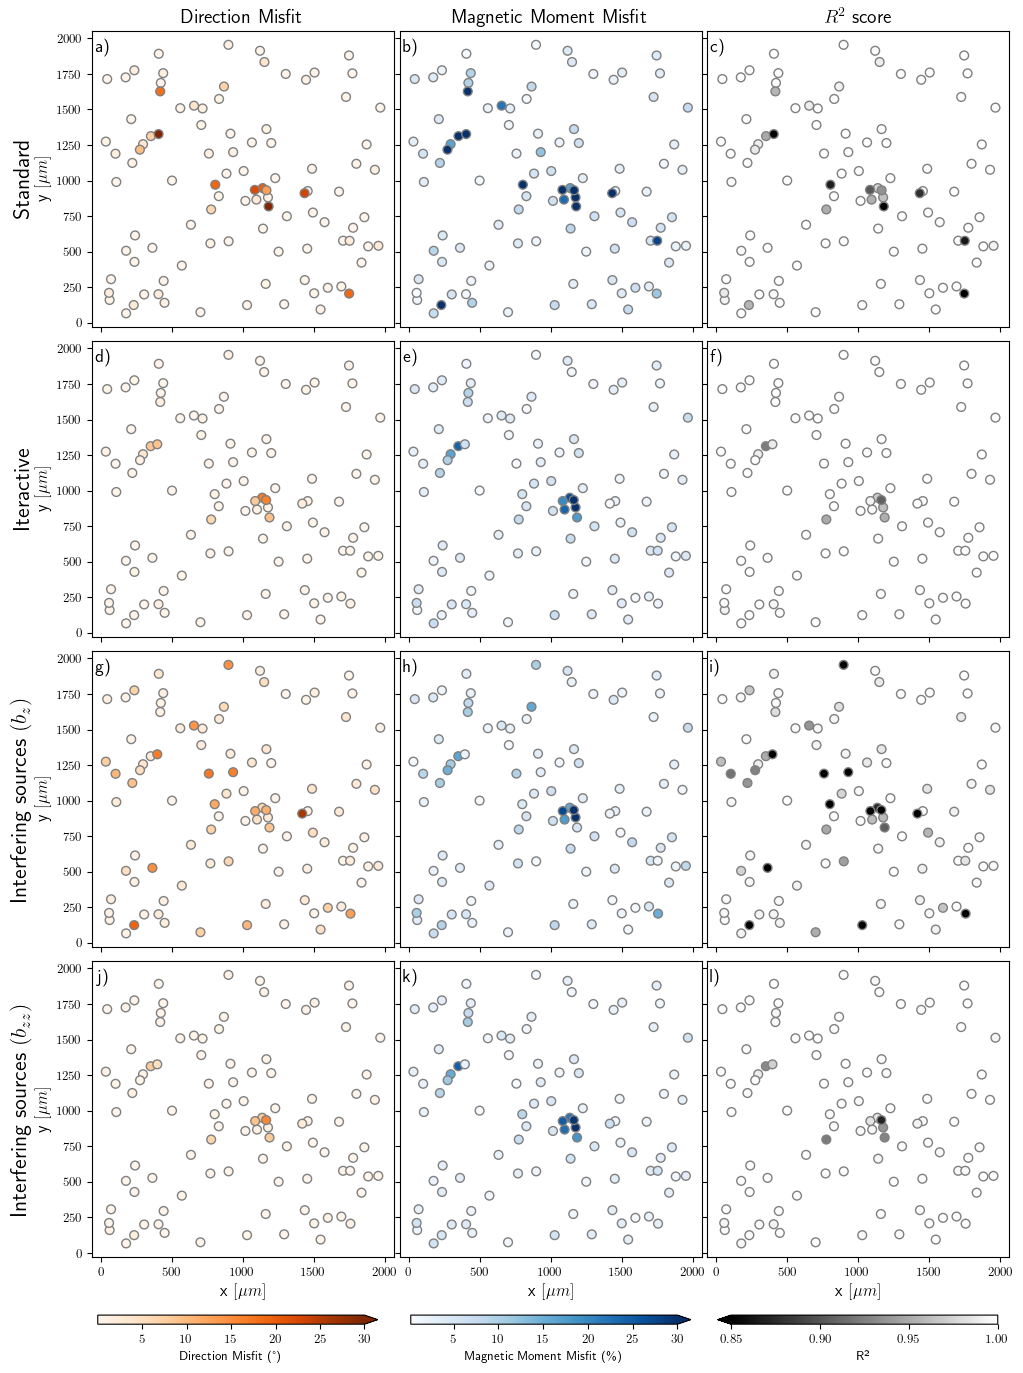

In [50]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(4, 3, figsize=(10, 13), sharey="row", sharex='col')
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.9)
    
    scale = 30
    ax = axes[0]
    # ax.set_title("Standard", fontsize=16)    
    ax.set_title("Direction Misfit", fontsize=14)    
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[3]
    # ax.set_title("Iteractive", fontsize=16)
    tmp = ax.scatter(*positions_itr[:2], c=direction_misfit_itr_euler, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')

    ax = axes[6]
    # ax.set_title(r"Interfering sources $(b_z)$", fontsize=16)    
    tmp = ax.scatter(*positions_itr[:2], c=direction_misfit_interf_bz, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    
    ax = axes[9]
    # ax.set_title(r"Interfering sources $(b_{zz})$", fontsize=16)    
    tmp = ax.scatter(*positions_itr[:2], c=direction_misfit_interf_z_deriv, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="Direction Misfit (°)", cax=fig.add_axes([0.085, -0.015, 0.28, 0.007]), extend='max')



    
    scale = 30
    ax = axes[1] 
    ax.set_title("Magnetic Moment Misfit", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Blues", vmax=scale, edgecolor='gray')

    ax = axes[4] 
    tmp = ax.scatter(*positions_itr[:2], c=magnetic_moment_misfit_itr_euler, s=40, cmap="Blues", vmax=scale, edgecolor='gray')
    
    ax = axes[7] 
    tmp = ax.scatter(*positions_itr[:2], c=magnetic_moment_misfit_interf_bz, s=40, cmap="Blues", vmax=scale, edgecolor='gray')

    ax = axes[10] 
    tmp = ax.scatter(*positions_itr[:2], c=magnetic_moment_misfit_interf_z_deriv, s=40, cmap="Blues", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label=r"Magnetic Moment Misfit (\%)", cax=fig.add_axes([0.398, -0.015, 0.28, 0.007]), extend='max')

    
    scale = 0.85
    ax = axes[2] 
    ax.set_title("$R^2$ score", fontsize=14) 
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    
    ax = axes[5]
    tmp = ax.scatter(*positions_itr[:2], c=calculated_r2_itr_euler, s=40, cmap="gray", vmin=scale, edgecolor='gray')
    
    ax = axes[8] 
    tmp = ax.scatter(*positions_itr[:2], c=calculated_r2_interf_bz, s=40, cmap="gray", vmin=scale, vmax=1, edgecolor='gray')

    ax = axes[11] 
    tmp = ax.scatter(*positions_itr[:2], c=calculated_r2_interf_z_deriv, s=40, cmap="gray", vmin=scale, vmax=1, edgecolor='gray')
    fig.colorbar(tmp, **cbar_kwargs, label="R²", cax=fig.add_axes([0.705, -0.015, 0.28, 0.007]), extend='min')

    for ax, letter in zip(axes, "a b c d e f g h i j k l".split()):
        ax.text(0.01, 0.93, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

    axes[0].set_ylabel(r'\fontsize{16}{0}\selectfont{Standard}'+'\n'+r'y $[\mu m]$', fontsize=12)
    axes[3].set_ylabel(r'\fontsize{16}{0}\selectfont{Iteractive}'+'\n'+r'y $[\mu m]$', fontsize=12)
    axes[6].set_ylabel(r'\fontsize{16}{0}\selectfont{Interfering sources $(b_z)$}'+'\n'+r'y $[\mu m]$', fontsize=12)
    axes[9].set_ylabel(r'\fontsize{16}{0}\selectfont{Interfering sources $(b_{zz})$}'+'\n'+r'y $[\mu m]$', fontsize=12)
    
    axes[9].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[10].set_xlabel(r'x $[\mu m]$', fontsize=12)
    axes[11].set_xlabel(r'x $[\mu m]$', fontsize=12)

    plt.tight_layout(pad=0, h_pad=0.0, w_pad=0.0)
    fig.savefig(fig_dir / "inversion-comparion-2.png", dpi=300, facecolor='w', bbox_inches='tight')
plt.show()   